In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# need this cell to import the help functions:

import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [3]:
# import help functions:

from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

from sklearn.linear_model import LinearRegression,LogisticRegression

In [4]:
data = CGMData()

In [5]:
# Finding 5/95th percentile idea from Dan Visscher

high_glu = []
low_glu = []

# Find 5th/95th percentile for glucose range for each patient
for i in range(1,3):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))




In [6]:
print(high_glu)
print(low_glu)

[137.0, 167.0]
[85.0, 99.0]


In [60]:
# participant_numbers = data.shape()
participant_numbers = 2

In [64]:
for pn in range(1,participant_numbers):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df2)])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 19
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        40 non-null     float64
 1   total_carb     40 non-null     float64
 2   dietary_fiber  6 non-null      float64
 3   sugar          40 non-null     float64
 4   protein        40 non-null     float64
 5   total_fat      6 non-null      float64
 6   recent_meals   40 non-null     float64
 7   participant    40 non-null     int64  
 8   max_glucose    40 non-null     int64  
 9   high_glucose   40 non-null     bool   
dtypes: bool(1), float64(7), int64(2)
memory usage: 3.2 KB


In [39]:
X = df[['total_carb','sugar','protein']]
y = df[['high_glucose']]
y

,high_glucose
0,True
1,False
2,False
3,False
4,False
5,False
6,False
7,True
8,False
9,False


In [40]:
log_reg = LogisticRegression(penalty=None)
X = df[['total_carb']]
y = df['high_glucose']

## fit the model
log_reg.fit(X,y)

LogisticRegression(penalty=None)

In [41]:
log_reg.coef_[0][0]

0.0027966625550914196

c:\Users\maggi\.conda\envs\erdos_may_2024\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


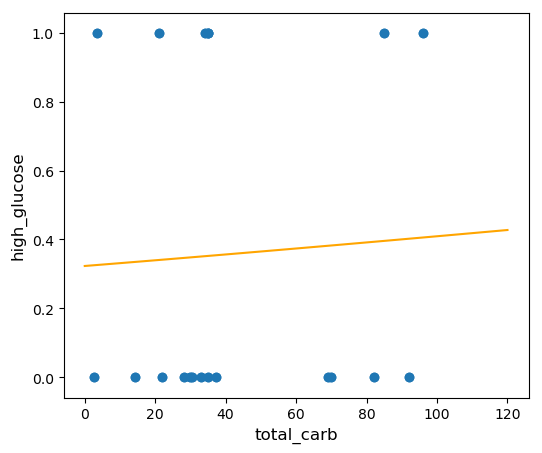

In [42]:
plt.figure(figsize=(6,5))

plt.scatter(X, y)

plt.plot(np.linspace(0,120), log_reg.predict_proba(np.linspace(0,160).reshape(-1,1))[:,1], color = 'orange')
#plt.plot(np.linspace(7,13), my_log_reg.predict_proba(np.linspace(7,13).reshape(-1,1)), c = 'k')

plt.xlabel("total_carb", fontsize=12)
plt.ylabel("high_glucose", fontsize=12)
plt.show()

next steps: 
1. put in data from all but the hold out participants
2. use first predictor project code to get baseline model predictions